In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from concurrent.futures import ThreadPoolExecutor
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.random import default_rng

import aria.distributions as dist
from aria.ppl.context import Context, Predictive
from aria.ppl.inference import (
    AIES,
    Chain,
    ParallelAIES,
)

In [3]:
def plot_theta_pairs(df: pd.DataFrame, truth=None, title: Optional[str] = None):
    # Initialize the PairGrid
    g = sns.PairGrid(df, corner=True)

    # Map the upper and lower triangles with scatter plots
    g.map_lower(sns.scatterplot)

    g.set(xlim=(0, 1), ylim=(0, 1))

    # Map the diagonal with histograms or KDE plots
    g.map_diag(sns.histplot)

    if truth is not None:
        # Iterate through each axis in the PairGrid
        for i, j in zip(*np.tril_indices_from(g.axes, -1)):
            ax = g.axes[i, j]
            # Add the custom point
            ax.scatter(  # type: ignore
                truth[j], truth[i], color="orange", s=100, edgecolor="k"
            )

    if title is not None:
        plt.suptitle(title)

    plt.tight_layout()

In [4]:
# Friedman function (Friedman, 1991, Multivariate Adaptive Regression Splines)
class Friedman:
    def __init__(self, theta):
        self.theta = theta

    def __call__(self, x):
        return (
            10.0 * np.sin(np.pi * self.theta[0] * x)
            + 20.0 * (self.theta[1] - 0.5) ** 2
            + 10 * self.theta[2]
            + 5.0 * self.theta[3]
        )

In [5]:
# Make data.
rng = np.random.default_rng(1)
theta_true = rng.uniform(0, 1, 6)  # using only first 4 elements.
f_true = Friedman(theta_true)
sigma_true = 0.5
grid_size = 30  # sample size
x = np.linspace(0, 1, grid_size)
y = rng.normal(f_true(x), sigma_true)

In [6]:
def model(ctx: Context, x, y):
    theta = ctx.rv("theta", dist.Uniform(np.zeros(6), 1))
    sigma = ctx.rv("sigma", dist.Gamma(1, 0.5))
    f = Friedman(theta)
    fx = ctx.cached("fx", f(x))
    ctx.rv("y", dist.Normal(fx, sigma), obs=y)

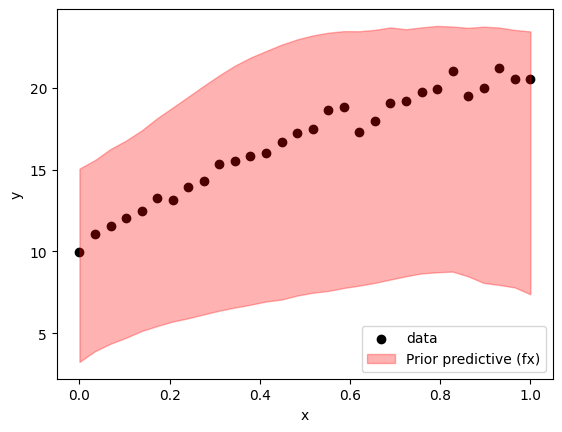

In [7]:
prior_predictive = Chain(
    Predictive.run(model, rng=rng, x=x, y=y) for _ in range(1000)
)
fx_prior = prior_predictive.get("fx")
plt.scatter(x, y, label="data", c="k")
plt.xlabel("x")
plt.ylabel("y")
plt.fill_between(
    x,
    np.quantile(fx_prior, 0.05, 0),
    np.quantile(fx_prior, 0.95, 0),
    color="red",
    alpha=0.3,
    label="Prior predictive (fx)",
)
plt.legend()
plt.show()

In [17]:
parallel = False

if parallel:
    # This will run in a script, but will not work in Jupyter notebook in
    # 3.13t.  You will not see speed ups unless you are using 3.13t.
    aies = ParallelAIES(
        model,
        y=y,
        x=x,
        nwalkers=10,
        rng=default_rng(1),
        transform=True,
        executor=ThreadPoolExecutor(),
    )
else:
    aies = AIES(
        model, y=y, x=x, nwalkers=10, rng=default_rng(1), transform=True
    )

# The default behavior is to reweight samples from the ensembles using
# importance sampling.
samples = aies.fit(nsteps=1000, burn=1000, thin=10)
aies.accept_rate

100%|██████████| 11000/11000 [00:09<00:00, 1188.68it/s]


array([0.2089, 0.1847, 0.1787, 0.2009, 0.1857, 0.1912, 0.2072, 0.1979,
       0.2217, 0.1993])

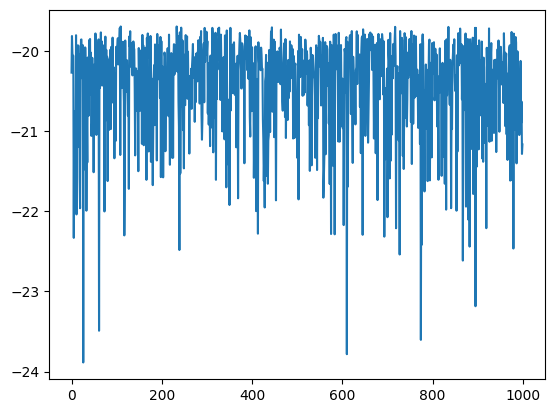

In [18]:
# Plot logprob history.
plt.plot(aies.resampled_logprob_history)
plt.show()

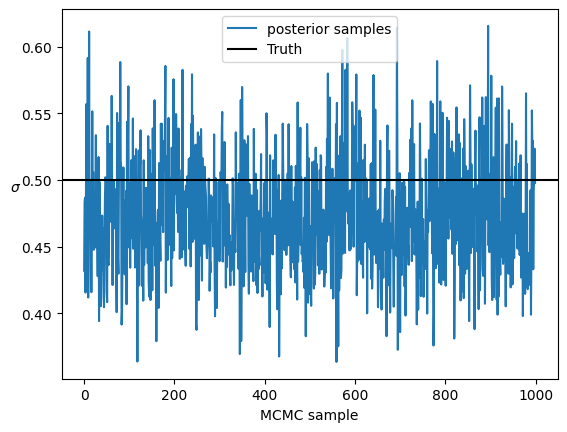

In [19]:
plt.plot(samples.get("sigma"), label="posterior samples")
plt.axhline(sigma_true, color="black", label="Truth")
plt.ylabel("$\sigma$", rotation=0)
plt.xlabel("MCMC sample")
plt.legend()
plt.show()

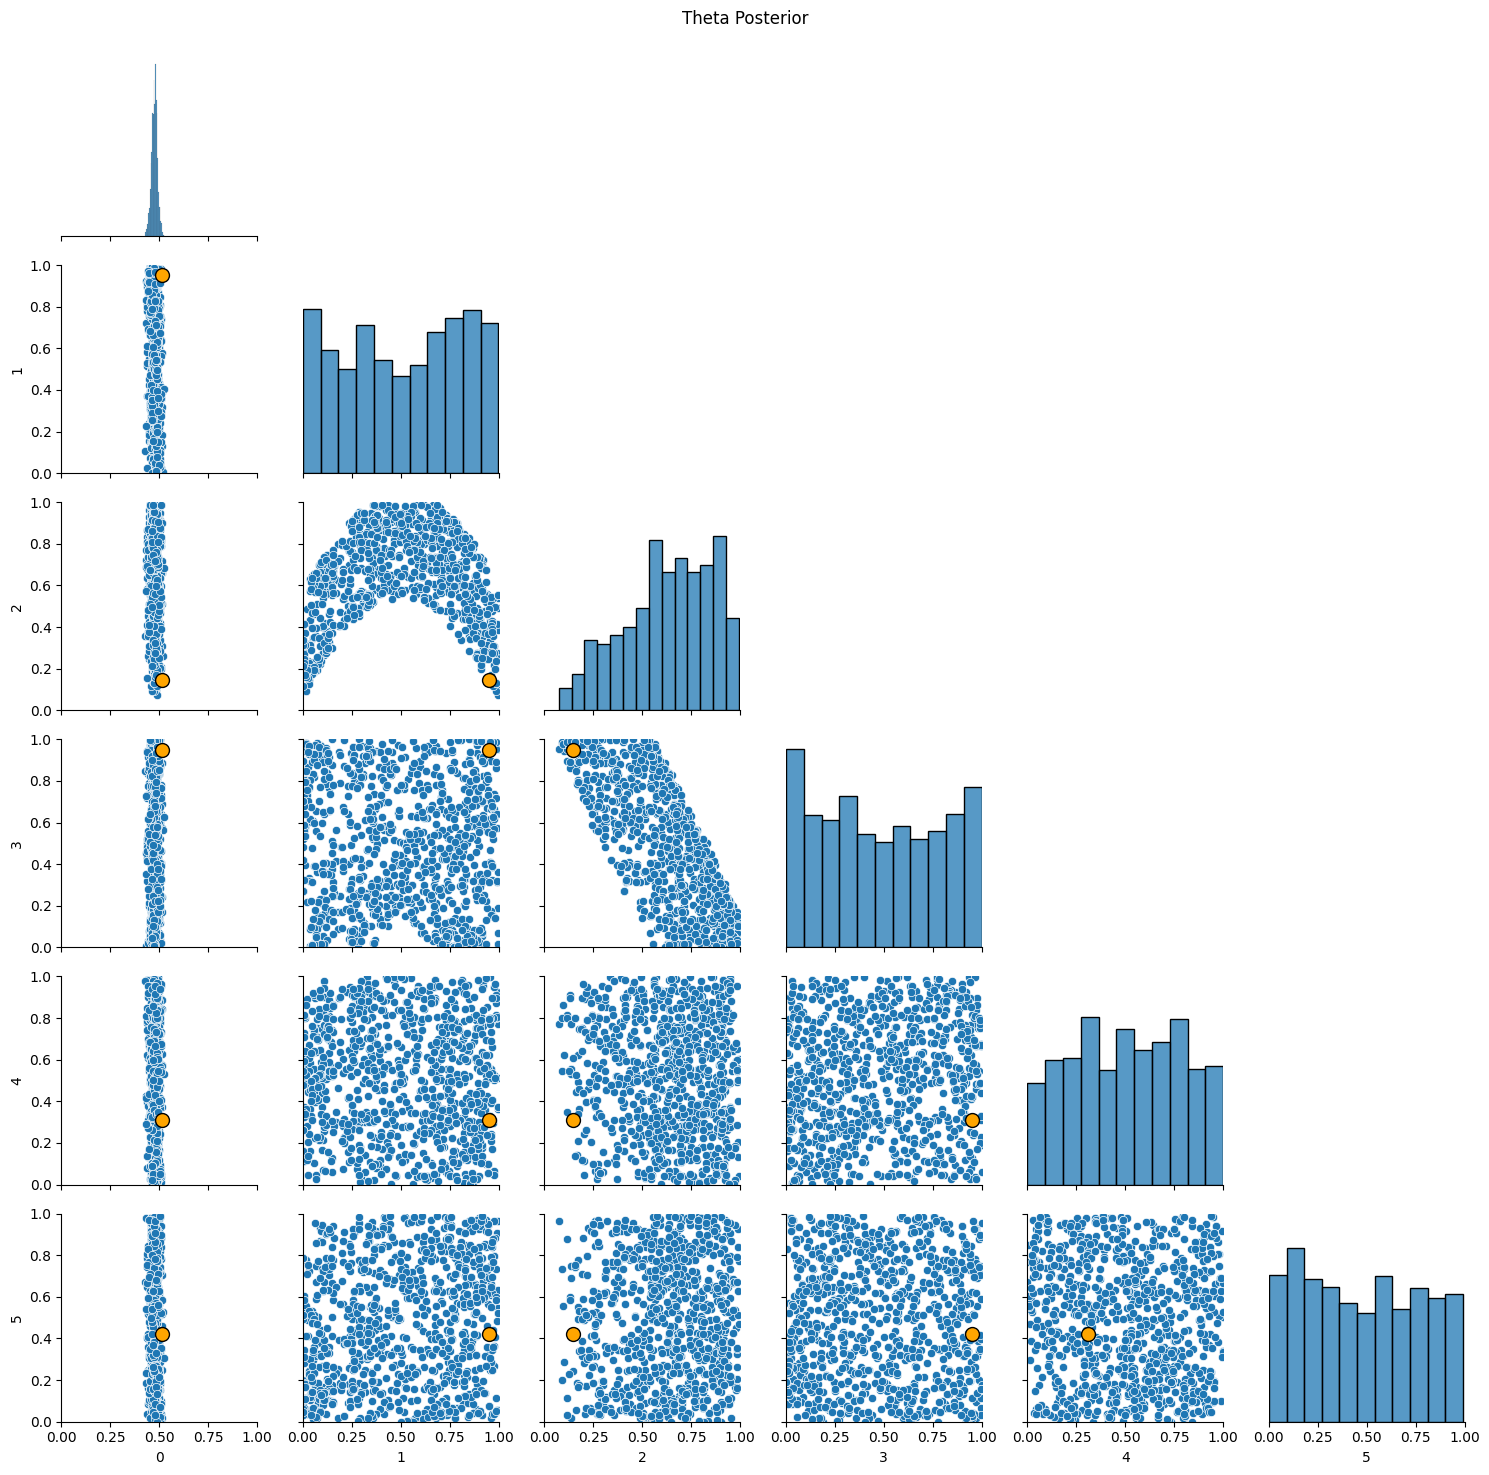

,0,1,2,3,4,5
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.476337,0.511925,0.628071,0.480268,0.508379,0.476343
std,0.015061,0.302358,0.224486,0.307684,0.276695,0.290834
min,0.429019,0.000083,0.073538,0.001267,0.000639,0.000521
25%,0.466306,0.255602,0.475081,0.211281,0.280679,0.206512
50%,0.476847,0.532210,0.651781,0.468201,0.513734,0.473771
75%,0.486208,0.776699,0.810819,0.763509,0.745267,0.731109
max,0.525908,0.999089,0.994073,0.999914,0.999850,0.990766


theta_true: [0.51182162 0.9504637  0.14415961 0.94864945 0.31183145 0.42332645]


In [20]:
theta_df = pd.DataFrame(samples.get("theta"))

plot_theta_pairs(theta_df, theta_true, "Theta Posterior")
plt.show()

display(theta_df.describe())
print("theta_true:", theta_true)

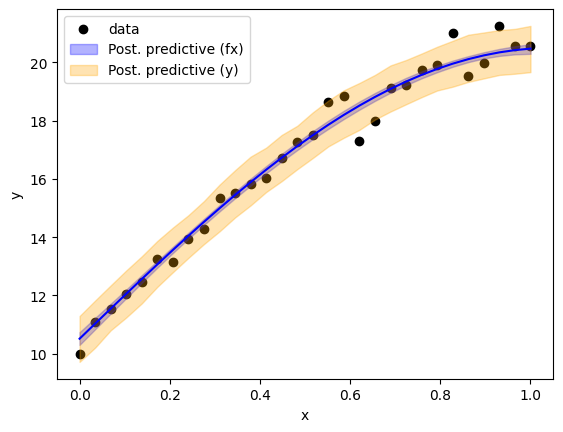

In [21]:
post_predictive = Chain(
    Predictive.run(model, x=x, y=None, rng=rng, state=state)
    for state in samples
)

fx_post = post_predictive.get("fx")
y_post = post_predictive.get("y")

plt.scatter(x, y, label="data", c="k")
plt.xlabel("x")
plt.ylabel("y")
plt.fill_between(
    x,
    np.quantile(fx_post, 0.05, 0),
    np.quantile(fx_post, 0.95, 0),
    color="blue",
    alpha=0.3,
    label="Post. predictive (fx)",
)
plt.plot(x, fx_post.mean(0), color="blue")

plt.fill_between(
    x,
    np.quantile(y_post, 0.05, 0),
    np.quantile(y_post, 0.95, 0),
    color="orange",
    alpha=0.3,
    label="Post. predictive (y)",
)

plt.legend()
plt.show()